In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision

In [4]:
url_path = '../99_DataSet/Data_Image/'
train_valid_data = torchvision.datasets.MNIST(root = url_path,
                            train=True,
                            download=True,
                            transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root = url_path,
                            train=False,
                            download=True,
                            transform=torchvision.transforms.ToTensor())

In [3]:
train_valid_length = len(train_valid_data)

rng = np.random.RandomState(0)
permute_indices = rng.permutation(range(train_valid_length))

valid_size = 0.2
sep_position = int(train_valid_length*(1-valid_size))

train_idx = permute_indices[:sep_position]
valid_idx =  permute_indices[sep_position:]

# n_samples = 10000
train_X = train_valid_data.data[train_idx].unsqueeze(1)/255
train_y = train_valid_data.train_labels[train_idx]
valid_X = train_valid_data.data[valid_idx].unsqueeze(1)/255
valid_y = train_valid_data.train_labels[valid_idx]
test_X = test_data.data.unsqueeze(1)/255
test_y = test_data.test_labels

train_data = torch.utils.data.TensorDataset(train_X, train_y)
valid_data = torch.utils.data.TensorDataset(valid_X, valid_y)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = batch_size, shuffle = True)


for batch_X, batch_y in train_loader:
    break
print(batch_X.shape,batch_y.shape)
# batch_X.max()

torch.Size([32, 1, 28, 28]) torch.Size([32])


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


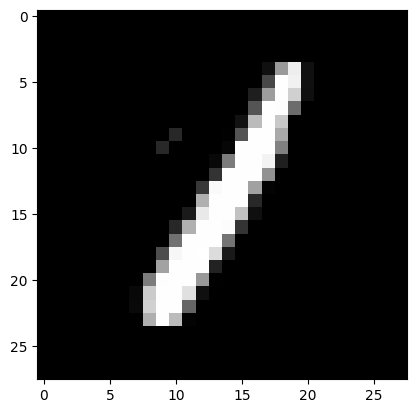

In [4]:
# Image
plt.figure()
plt.imshow(batch_X[1,0], cmap='gray')
plt.show()

In [5]:
# use_cuda = False
#  if use_cuda and torch.cuda.is_available():
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
# torch.cuda.empty_cache()

cuda:0


In [8]:
# GAN Generator
class GAN_Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = torch.nn.Sequential(
            torch.nn.Linear(100, 256*7*7, bias=False)
            ,torch.nn.BatchNorm1d(256*7*7)
            ,torch.nn.LeakyReLU()
            
            ,torch.nn.Unflatten(1, (256, 7, 7))
            
            ,torch.nn.ConvTranspose2d(256, 128, 5, 1, 2, bias=False)    # (128, 7, 7)
            ,torch.nn.BatchNorm2d(128)
            ,torch.nn.LeakyReLU()
            ,torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)    # (64, 14, 14)
            ,torch.nn.BatchNorm2d(64)
            ,torch.nn.LeakyReLU()
            ,torch.nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)    # (1, 28, 28)
            ,torch.nn.Tanh()
        )
        
    def forward(self, x):
        return self.generator(x)


# sample_noise = torch.randn((5,100))
# gg = GAN_Generator()
# gg(sample_noise).shape
# gen_image = gg(sample_noise)

# plt.figure()
# plt.imshow(gen_image[0,0].to('cpu').detach().numpy(), cmap='gray')
# plt.show()

In [9]:
# GAN Discriminator
class GAN_Discriminator(torch.nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 4, 2, 1)         # (64, 14, 14)
            ,torch.nn.BatchNorm2d(64)
            ,torch.nn.LeakyReLU(negative_slope=0.2)
            # ,torch.nn.Dropout(dropout)
            
            ,torch.nn.Conv2d(64, 128, 4, 2, 1)      # (128, 7, 7)
            ,torch.nn.BatchNorm2d(128)
            ,torch.nn.LeakyReLU(negative_slope=0.2)
            # ,torch.nn.Dropout(dropout)
            
            ,torch.nn.Flatten()     # (128*7*7)
            
            ,torch.nn.Linear(128*7*7, 1)    
            ,torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.discriminator(x)
        

# sample_X = torch.rand(5,1,28,28)
# gd = GAN_Discriminator()
# gd(sample_X).shape
# gd(gen_image)

In [10]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

In [11]:
# model initialize
mdl_generator = GAN_Generator().to(device)
mdl_discriminator = GAN_Discriminator().to(device)

In [12]:
# loss function & optimizer
loss_function = torch.nn.BCELoss()

lr = 1e-4
beta1 = 0.5
optimizer_gen = torch.optim.RMSprop(mdl_generator.parameters(), lr=lr)
optimizer_dis = torch.optim.RMSprop(mdl_discriminator.parameters(), lr=lr)

# optimizer_gen = torch.optim.Adam(mdl_generator.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_dis = torch.optim.Adam(mdl_discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
n_epochs = 30

In [16]:
train_losses = []
valid_losses = []
fixed_noise = torch.randn(1, 100).to(device)  # 고정된 z를 사용해 생성된 이미지를 저장하기 위해 사용
fixed_noise_images = []

In [17]:
for e in range(n_epochs):
    start_time = time.time() # 시작 시간 기록
    
    mdl_discriminator.train()
    mdl_generator.train()
    train_epoch_loss = []
    for batch_X, batch_y in train_loader:
        # [Discriminator] --------------------------------------------------------------
        optimizer_dis.zero_grad()      # optimizer initialize
        
        # (Objective Funciton)  min_θ max_Φ E[log{D_Φ(x)}] + E[log{1-D_Φ(G_θ(z))}]
        
        # discriminator forward
        output_real = mdl_discriminator(batch_X.to(device))
        label_true = torch.ones_like(output_real).to(device)
        loss_real = loss_function(output_real, label_true)
        
        # generator forward
        noise_X = torch.randn([batch_X.shape[0], 100]).to(device)   # noise
        gen_X = mdl_generator(noise_X)
        output_fake = mdl_discriminator(gen_X.detach())
        label_fake = torch.zeros_like(output_fake).to(device)
        loss_fake = loss_function(output_fake, label_fake)
        
        loss_dis = loss_real + loss_fake
        
        loss_dis.backward()         # backward
        optimizer_dis.step()        # weight update
        
        # [Generator] --------------------------------------------------------------
        optimizer_gen.zero_grad()      # optimizer initialize
        output_fake = mdl_discriminator(gen_X)
        
        loss_gen = loss_function(output_fake, label_true)
        
        loss_gen.backward()
        optimizer_gen.step()
        
        with torch.no_grad():
            train_batch_loss = (loss_dis.to('cpu').detach().numpy(), loss_gen.to('cpu').detach().numpy())
            train_epoch_loss.append( train_batch_loss )
    
    # valid_set evaluation *
    valid_epoch_loss = []
    with torch.no_grad():
        mdl_discriminator.eval()
        mdl_generator.eval()
        for batch_X, batch_y in valid_loader:
            # [Discriminator] 
            # discriminator forward
            output_real = mdl_discriminator(batch_X.to(device))
            label_true = torch.ones_like(output_real).to(device)
            loss_real = loss_function(output_real, label_true)
            
            # generator forward
            noise_X = torch.randn([batch_X.shape[0], 100]).to(device)   # noise
            gen_X = mdl_generator(noise_X)
            output_fake = mdl_discriminator(gen_X.detach())
            label_fake = torch.zeros_like(output_fake).to(device)
            loss_fake = loss_function(output_fake, label_fake)
            
            loss_dis = loss_real + loss_fake
            
            # [Generator] 
            optimizer_gen.zero_grad()      # optimizer initialize
            output_fake = mdl_discriminator(gen_X)
            
            loss_gen = loss_function(output_fake, label_true)
            
            # (total loss)
            valid_batch_loss = (loss_dis.to('cpu').detach().numpy(), loss_gen.to('cpu').detach().numpy())
            valid_epoch_loss.append( valid_batch_loss )

    # save generated image from fixed_noise
    with torch.no_grad():
        mdl_generator.eval()
        fixed_generate_image = mdl_generator(fixed_noise)
        fixed_noise_images.append(fixed_generate_image)
    
    # evaluate GAN models
    with torch.no_grad():
        train_loss = np.stack(train_epoch_loss).mean(0)
        valid_loss = np.stack(valid_epoch_loss).mean(0)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time() # 종료 시간 기록
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {e + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t(Train) Total: {train_loss.sum():.3f} | Discriminator Loss: {train_loss[0]:.3f} | Generator Loss: {train_loss[1]:.3f}')
        print(f'\t(Valid) Total: {valid_loss.sum():.3f} | Discriminator Loss: {valid_loss[0]:.3f} | Generator Loss: {valid_loss[1]:.3f}')

Epoch: 01 | Time: 0m 22s
	(Train) Total: 4.363 | Discriminator Loss: 0.150 | Generator Loss: 4.212
	(Valid) Total: 4.625 | Discriminator Loss: 0.400 | Generator Loss: 4.225
Epoch: 02 | Time: 0m 13s
	(Train) Total: 5.859 | Discriminator Loss: 0.059 | Generator Loss: 5.800
	(Valid) Total: 3.501 | Discriminator Loss: 0.138 | Generator Loss: 3.363
Epoch: 03 | Time: 0m 14s
	(Train) Total: 5.554 | Discriminator Loss: 0.051 | Generator Loss: 5.502
	(Valid) Total: 5.875 | Discriminator Loss: 0.275 | Generator Loss: 5.600
Epoch: 04 | Time: 0m 14s
	(Train) Total: 5.236 | Discriminator Loss: 0.085 | Generator Loss: 5.152
	(Valid) Total: 3.592 | Discriminator Loss: 0.232 | Generator Loss: 3.360
Epoch: 05 | Time: 0m 13s
	(Train) Total: 5.141 | Discriminator Loss: 0.078 | Generator Loss: 5.063
	(Valid) Total: 3.369 | Discriminator Loss: 0.153 | Generator Loss: 3.215
Epoch: 06 | Time: 0m 13s
	(Train) Total: 5.194 | Discriminator Loss: 0.081 | Generator Loss: 5.113
	(Valid) Total: 3.929 | Discriminato

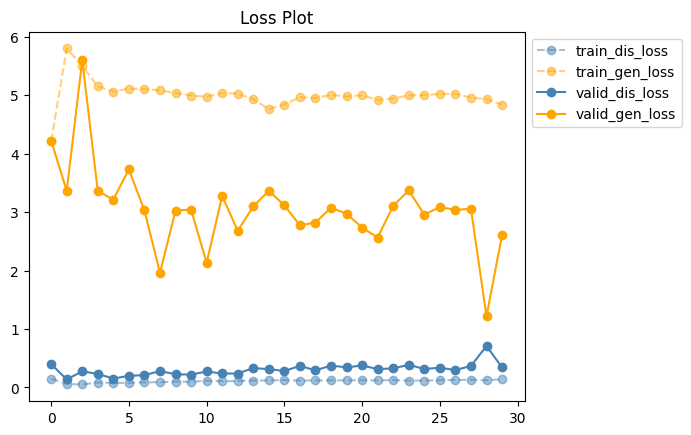

In [18]:
# loss map
plt.figure()
plt.title('Loss Plot')
plt.plot(np.stack(train_losses)[:,0], marker='o', color='steelblue', ls='--', alpha=0.5, label='train_dis_loss')
plt.plot(np.stack(train_losses)[:,1], marker='o', color='orange', ls='--', alpha=0.5, label='train_gen_loss')

plt.plot(np.stack(valid_losses)[:,0], marker='o', color='steelblue', label='valid_dis_loss')
plt.plot(np.stack(valid_losses)[:,1], marker='o', color='orange', label='valid_gen_loss')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [19]:
def image_map(noises=None, gen_outputs=None, generator=None, n_w=8, digit_h=28, digit_w=28):
    """
    h_v : heigt_vector (ex. np.linsapce(-1, 1, 10))
    w_v : width_vector (ex. np.linsapce(-1, 1, 10))
    generator : callable function model's generator (ex. model.generate )
    """
    if noises is not None:
        assert generator is not None, "noises must need 'generator'"
        n_h = (len(noises)-1) // n_w + 1
        
        with torch.no_grad():
            generator.eval()
            gen_outputs = generator(noises).to('cpu')

    elif gen_outputs is not None:
        n_h = (len(gen_outputs)-1) // n_w + 1
        gen_outputs = np.stack(map(lambda x: x.squeeze().to('cpu').numpy(), gen_outputs))

    gen_map = np.zeros((n_h*digit_h, n_w*digit_w))

    for e, gen_img in enumerate(gen_outputs):
        rs = (e // n_w) * digit_h
        cs = ((e - (e // n_h) * n_w) % n_w) * digit_w
        gen_map[rs:rs+digit_h, cs:cs+digit_w] = gen_img.squeeze()
        
    return gen_map

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


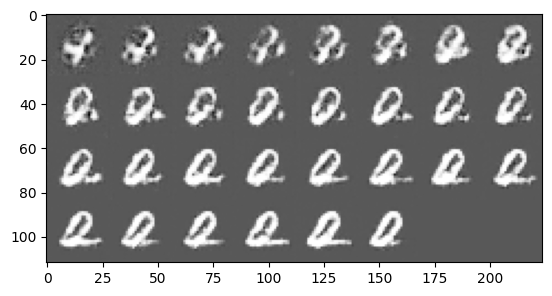

In [20]:
plt.imshow(image_map(gen_outputs=fixed_noise_images), 'gray')
plt.show()

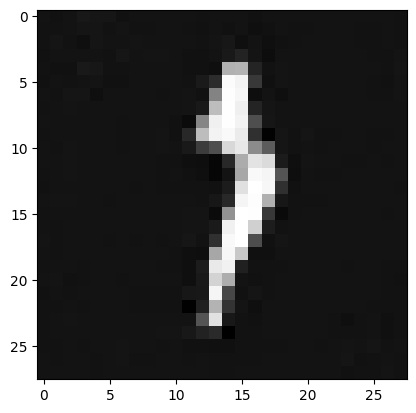

In [26]:
# generate image random noise (one by one)
sample_noise = torch.randn(1, 100).to(device)
with torch.no_grad():
    mdl_generator.eval()
    sample_generate_image = mdl_generator(sample_noise)
    plt.imshow(sample_generate_image[0].squeeze().to('cpu'), 'gray')
    plt.show()

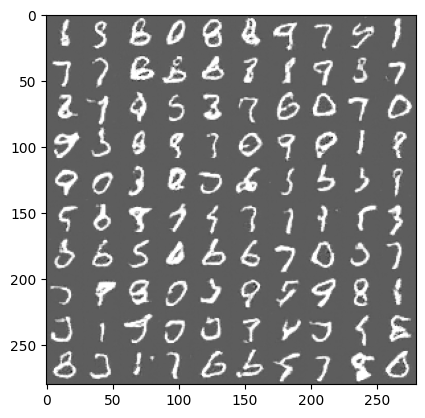

In [24]:
# generate image random noise (all)
plt.imshow(image_map(torch.randn(100, 100).to(device), generator=mdl_generator, n_w=10), cmap='gray')
plt.show()